# Crystal Melting Rates

In [1]:
import numpy as np
import pandas
import altair as alt
import scipy.stats

from ipywidgets import interact, ToggleButtons, fixed

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
# Read file with melting data
norm_df = pandas.read_hdf('../data/analysis/melting.h5', 'fractions', mode='r')
norm_df.columns = [col.replace('-', '_') for col in norm_df.columns]
norm_df = norm_df.query('volume > 4000 and volume < 24000')

group_bys = ['crystal', 'temperature', 'state', 'pressure']
time_df = norm_df.copy()
time_df.index = pandas.TimedeltaIndex(norm_df.time)
time_df = time_df.groupby(group_bys).resample('1ms').mean().reset_index(group_bys)

df_high = time_df.query('pressure == "13.50"').copy()
# df_high = df_high.groupby(group_bys).resample('5ms').mean().reset_index(group_bys)

df_low = time_df.query('pressure == "1.00"').copy()

In [3]:
time_df.head(3)

,crystal,temperature,state,pressure,fraction,surface_area,volume,time
00:00:00,p2,0.30,liq,1.00,0.540833,535.856542,18650.612912,0.0
00:00:00.001000,p2,0.30,liq,1.00,0.539722,536.833240,18593.452884,1000000.0
00:00:00.002000,p2,0.30,liq,1.00,0.541667,536.403577,18759.004015,2000000.0


In [4]:
def create_figure(temp, dataset, field="fraction"):
    c = alt.Chart(dataset).mark_line().encode(
        alt.X('time', axis=alt.Axis(format='e', title='Timesteps (t)')),
        alt.Y(field),
        alt.Column('crystal', header=alt.Header(title='Initial Crystal')),
        alt.Row('pressure', header=alt.Header(title='Pressure')),
    ).transform_calculate(
        'percentage', 'datum.fraction * 100'
    ).transform_filter(
        alt.datum.temperature == temp
    )
    if field == 'fraction':
        c = c.encode(alt.Color('state', legend=alt.Legend(title='Classification')))
    return c

def compute_melting_rates(df):
    slopes = []
    errors = []
    for index, group in df.groupby(['temperature', 'pressure', 'crystal']):
        # find fraction melted
        subgroup =  group.query('state == "liq" and fraction < 0.95 and surface_area > 0')
        subgroup = subgroup.dropna()
        if len(subgroup) < 5:
            continue
        values = np.gradient(subgroup.volume, subgroup.time) / subgroup['surface_area']
        slopes.append((*index, values.mean()))
        errors.append(values.std())

    melt = pandas.DataFrame(slopes)
    melt.columns = ['temperature', 'pressure', 'crys', 'melting_rate']
    melt["error"] = errors
    melt.temperature = melt.temperature.astype(float)
    melt.melting_rate = melt.melting_rate
    return melt

## Low Pressure

In [5]:
temp_select = ToggleButtons(
    options=sorted(df_low.temperature.unique()),
    description='Temperature:',
)
field_select = ToggleButtons(
    options=['fraction', 'surface_area', 'volume'],
    description="Field:"
)

interact(create_figure, temp=temp_select, dataset=fixed(df_low), field=field_select)

<function __main__.create_figure(temp, dataset, field='fraction')>

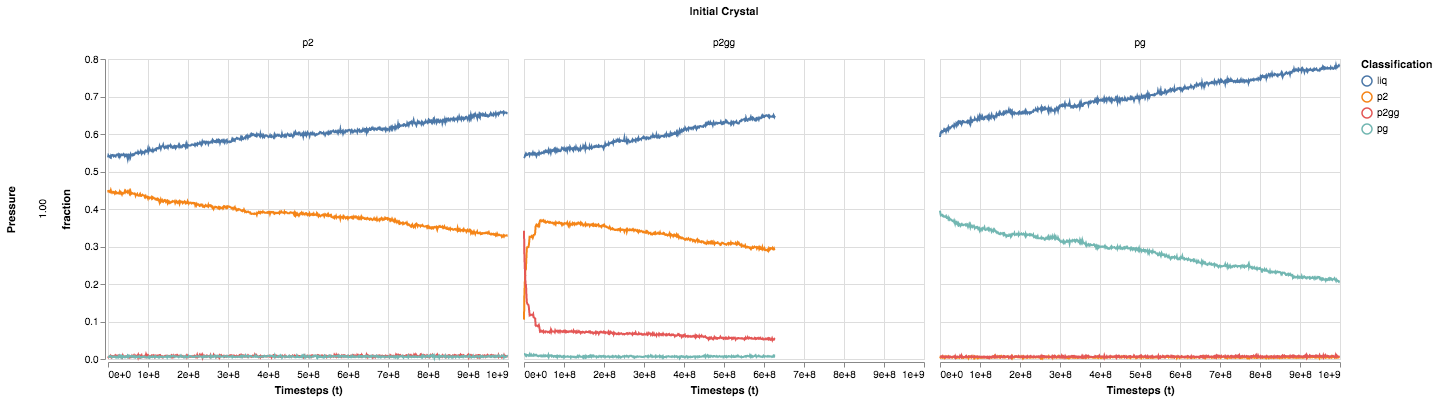

In [6]:
create_figure(temp='0.38', dataset=df_low)

In [7]:
melt_low = compute_melting_rates(df_low)

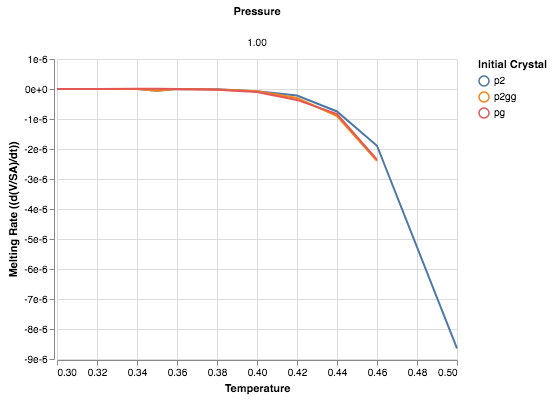

In [8]:
alt.Chart(melt_low).mark_line().encode(
    alt.X('temperature', axis=alt.Axis(title='Temperature'), scale=alt.Scale(zero=False)),
    alt.Y('melting_rate', axis=alt.Axis(format='e', title='Melting Rate ((d(V/SA)/dt))')),
    alt.Color('crys', legend=alt.Legend(title='Initial Crystal')),
    alt.Column('pressure', header=alt.Header(title='Pressure')), 
).transform_filter(
    alt.datum.temperature < 0.55
)

## High Pressure

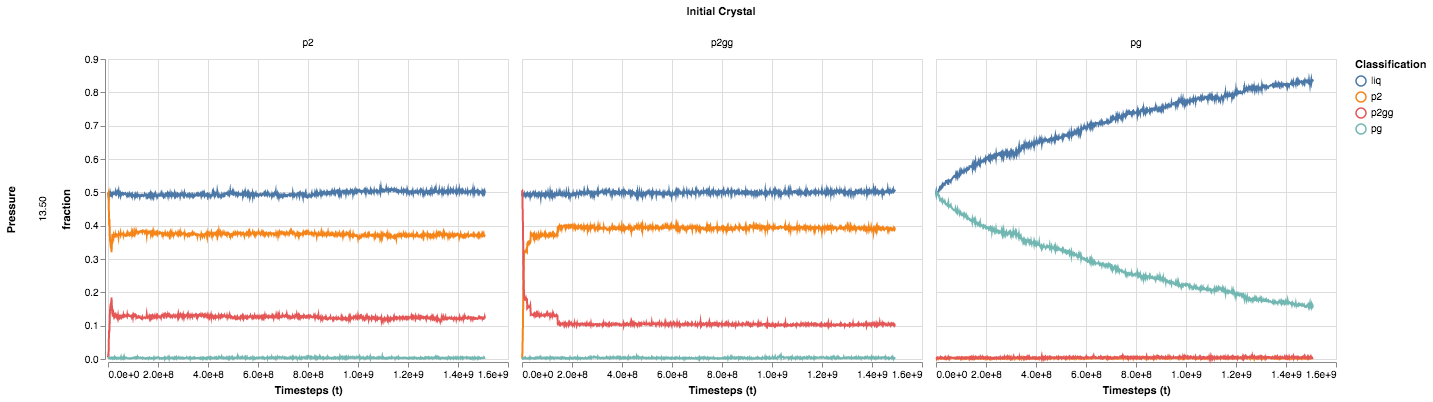

<function __main__.create_figure(temp, dataset, field='fraction')>

In [9]:
temp_select = ToggleButtons(
    options=sorted(df_high.temperature.unique()),
    description='Temperature:',
)

interact(create_figure, temp=temp_select, dataset=fixed(df_high), field=field_select)

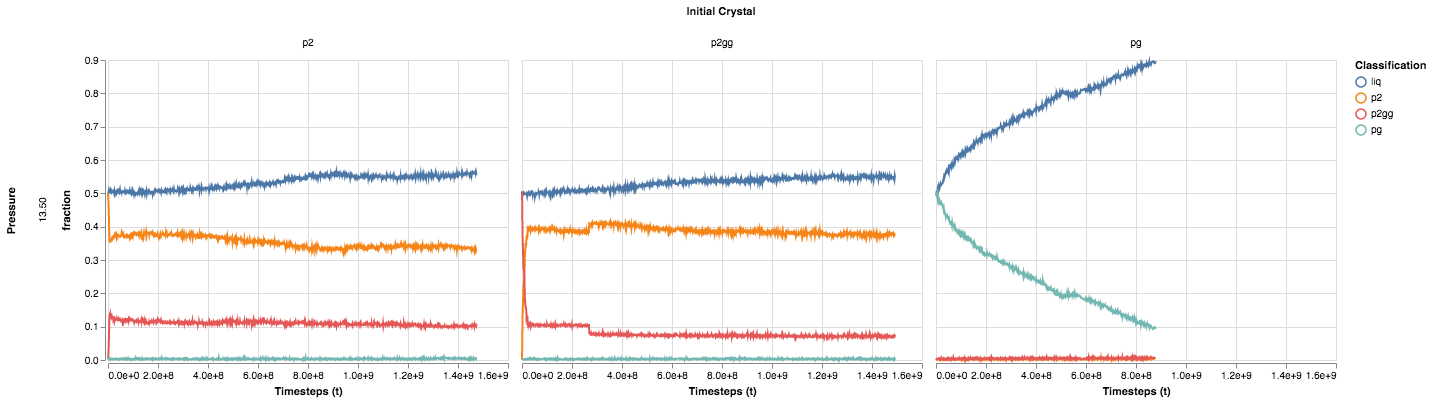

In [10]:
create_figure(temp='1.35', dataset=df_high)

In [11]:
melt_high = compute_melting_rates(df_high)

In [12]:
melt_high

,temperature,pressure,crys,melting_rate,error
0,1.30,13.50,p2,3.269868e-10,4.634134e-07
1,1.30,13.50,p2gg,1.809917e-09,1.653541e-07
2,1.30,13.50,pg,-9.587678e-09,1.998604e-07
3,1.35,13.50,p2,-1.827206e-09,1.326128e-07
4,1.35,13.50,p2gg,1.733023e-11,1.883961e-07
5,1.35,13.50,pg,-2.168197e-08,2.522680e-07
6,1.40,13.50,p2,-8.285458e-09,1.509836e-07
7,1.40,13.50,p2gg,-3.988558e-09,1.776252e-07
8,1.40,13.50,pg,-3.611491e-08,2.315285e-07
9,1.45,13.50,p2,-1.942587e-08,1.843101e-07


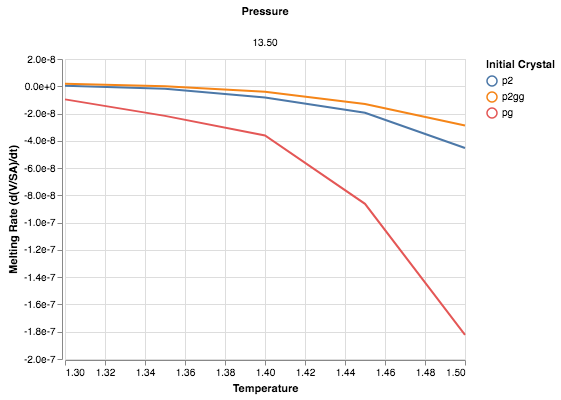

In [13]:
alt.Chart(melt_high).mark_line().encode(
    x=alt.X('temperature', axis=alt.Axis(title='Temperature'), scale=alt.Scale(zero=False)),
    y=alt.Y('melting_rate', axis=alt.Axis(format='e', title='Melting Rate (d(V/SA)/dt)')),
    color=alt.Color('crys', legend=alt.Legend(title='Initial Crystal')),
    column=alt.Column('pressure', header=alt.Header(title='Pressure')), 
)

In [14]:
pandas.concat([melt_high, melt_low]).to_hdf('../data/analysis/melting.h5', 'rates')